### Import Packages

In [1]:
import numpy as np
import networkx as nx
import torch
import matplotlib.pyplot as plt
import os
import sys
import copy
from tensor_solver import TensorSolver
import pandas as pd

### Generating the 2-layer network from Twitter data

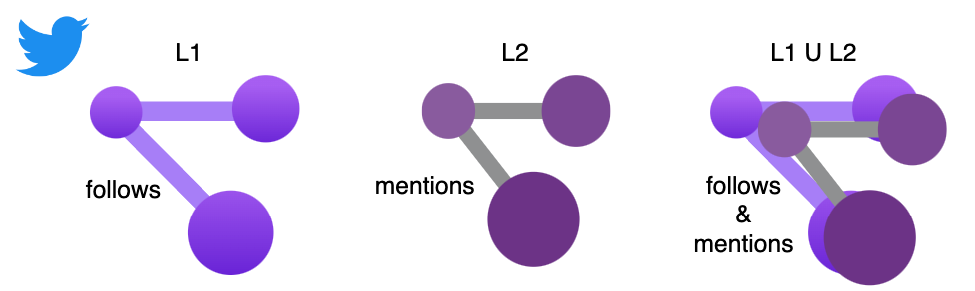

### Load network

In [2]:
#The stochastic matrix of G's adjacency
def weighted(G, make_self = False):
    A = nx.adjacency_matrix(G).todense()
    con = 0
    for i in range(len(G.nodes())): 
        if (np.sum(A[i,:])==0):
            A[i,i] = 1
            con+=1
    return torch.from_numpy((A.T*1/A.sum(axis = 1).T).T)

#Graph from edge list file
def read_edge_list(filename, n = 3409):
    G = nx.Graph()
    for i in range(n): 
        G.add_node(i)
    with open(filename) as file:
        for line in file:
            u = int(line.split(' ')[0])
            v = int(line.split(' ')[1][0:-1])
            G.add_edge(u,v)
    return G

#Loading Twitter data
def load_real_data(n):
    Ws = []
    G1 = read_edge_list(f'./Twitter/G_v_scc.edgelist', n)
    G2 = read_edge_list(f'./Twitter/G_vax_scc.edgelist', n)
    Ws.append(weighted(G1))
    Ws.append(weighted(G2))
    A1 = nx.adjacency_matrix(G1).todense()
    A2 = nx.adjacency_matrix(G2).todense()
    for i in range(n): 
        if np.sum(A1[i,:])==0: A1[i,i] = 1
    for i in range(n): 
        if np.sum(A2[i,:])==0: A2[i,i] = 1
    Ws.append((torch.from_numpy(((A1+A2).T*1/(A1+A2).sum(axis = 1).T).T)))
    return Ws

### Predictions
$$x_u(t)=\alpha_us_u+(1-\alpha_u)\sum\limits_{\ell\in[L]}\lambda_{\ell}\mathbf{w}^{\top}_{l,u}\mathbf{x}(t-1)$$

In [3]:
#Given initial opinions (s), the resistance parameters (alphas),
#the layer weights (lambdas), the weighted adjacency matrices (W) and 
#the opinions at time t (x(t)), function returns opinions at t+1 (x(t+1)).
def predict(s, alphas, lambdas, W, xt):
    n = len(s)
    xt_plus_1 = alphas*s
    for u in range(n): 
        for l in range(len(lambdas)):
            xt_plus_1[u] += float((1-alphas[u])*lambdas[l]*(W[l][u,:].reshape(1,n)@xt))
    return xt_plus_1

### Run the experiments

In [4]:
def split_train_and_test_data(n, ops_all, T_train, T_test):
    x_train = [ops_all[i].reshape(n, 1) for i in range(T_train)]
    y_train = [ops_all[i].reshape(n, 1) for i in range(1,T_train+1)]
    x_test = [ops_all[i].reshape(n, 1) for i in range(T_train, T_train+T_test)]
    y_test = [ops_all[i].reshape(n, 1) for i in range(T_train+1, T_train+T_test+1)]
    return x_train, y_train, x_test, y_test 


def run_the_experiments(n, algname):
    _start = 0
    _end = 1000
    _step = 100
    T_train = 90
    T_test = 10
    
    results = {}
    results['train_loss'] = []
    results['test_loss'] = []
    results['alphas'] = []
    results['lambdas'] = []
    for start_point in range(_start, _end, _step):
        Ws = load_real_data(n)
        ops_all = np.array(pd.read_csv(f'./Twitter/vax_ops.txt', sep=' ', header=None))/10
        s_ = torch.from_numpy(ops_all[:,0].reshape(n,1))
        x_train, y_train, x_test, y_test  = split_train_and_test_data(n, 
                                             torch.from_numpy(ops_all[:,start_point:start_point+T_train+T_test+1].T), 
                                             T_train, T_test)
        Ws_ = copy.deepcopy(Ws)
        if algname == 'multi': Ws_ = [[Ws[0], Ws[1]]]
        elif algname == 'l1': Ws_ = [[Ws[0], Ws[0]]]
        elif algname == 'l2': Ws_ = [[Ws[1], Ws[1]]]
        elif algname == 'lboth': Ws_ = [[Ws[2], Ws[2]]]
        else: return
        solver  = TensorSolver(s_, Ws_, x_train, y_train)
        train_loss = solver.training(num_epochs = 100, lrdiv = 10, printall = False, printL1 = True) #change False to True for printing loss
        test_loss = []
        for t in range(T_test):
            test_loss.append(torch.nn.L1Loss()(predict(s_, 
                                                       solver.lambdas.detach()[:-2], 
                                                       solver.lambdas.detach()[-2:].reshape(-1), 
                                                       Ws_[0], 
                                                       x_test[t]).reshape(n,1), y_test[t].reshape(n,1)).numpy())
        print(f'Algorithm {algname}')
        print('Test Loss: ', test_loss)
        results['train_loss'].append(train_loss)
        results['test_loss'].append(np.mean(test_loss))
        results['alphas'].append(solver.lambdas.detach().numpy()[:-2])
        results['lambdas'].append(solver.lambdas.detach().numpy()[-2:])    
    return results

n = 430
alg_results = {}
for algname in ['multi', 'l1', 'l2', 'lboth']: 
    alg_results[algname] = run_the_experiments(n, algname)

Algorithm multi
Test Loss:  [array(0.05809048), array(0.05866303), array(0.06078086), array(0.06198954), array(0.06201102), array(0.0618327), array(0.06025035), array(0.06152332), array(0.06314293), array(0.06413259)]
Algorithm multi
Test Loss:  [array(0.07413836), array(0.07338776), array(0.07486921), array(0.07545562), array(0.0724921), array(0.07377085), array(0.07816701), array(0.07890137), array(0.07944924), array(0.07825252)]
Algorithm multi
Test Loss:  [array(0.07356493), array(0.07447713), array(0.07529317), array(0.07670945), array(0.07646919), array(0.07857436), array(0.07913252), array(0.08111416), array(0.08096304), array(0.08327891)]
Algorithm multi
Test Loss:  [array(0.12854682), array(0.12902743), array(0.12982842), array(0.12948071), array(0.13051236), array(0.12926396), array(0.13092633), array(0.13138998), array(0.13033643), array(0.12957414)]
Algorithm multi
Test Loss:  [array(0.14903265), array(0.1483122), array(0.14847917), array(0.15005998), array(0.15105685), arr

Algorithm lboth
Test Loss:  [array(0.10899559), array(0.10942678), array(0.10895312), array(0.10852935), array(0.10920636), array(0.10894459), array(0.10864965), array(0.10778195), array(0.11086445), array(0.11092764)]
Algorithm lboth
Test Loss:  [array(0.13220078), array(0.13587972), array(0.13690804), array(0.13549719), array(0.13782488), array(0.13658439), array(0.13464782), array(0.13444187), array(0.13398417), array(0.13454711)]


### Average results

In [5]:
for algname in alg_results:
    alg_results[algname]['train_loss_mean'] = np.mean(alg_results[algname]['train_loss'], axis = 0)
    alg_results[algname]['test_loss_mean'] = np.mean(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['test_loss_std'] = np.std(alg_results[algname]['test_loss'], axis = 0)
    alg_results[algname]['alphas_mean'] = np.mean(alg_results[algname]['alphas'], axis = 0)
    alg_results[algname]['lambdas_mean'] = np.mean(alg_results[algname]['lambdas'], axis = 0)

### Plot average train loss vs epochs

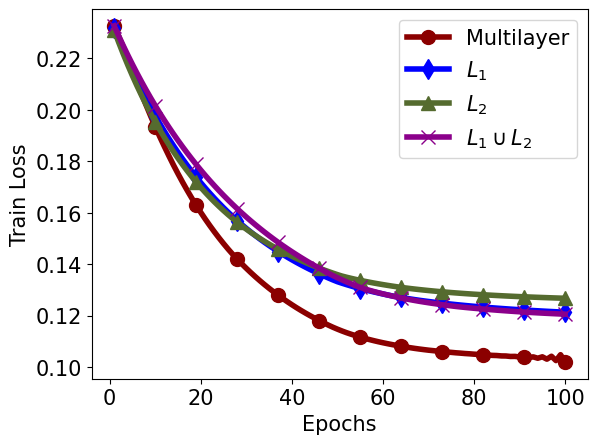

In [6]:
def plot_train_loss(alg_results):
    fig, axes = plt.subplots(1)
    m = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    markers = ["o", "d", "^", "x"]
    ax1 = axes
    j = 0
    for algname in alg_results:
        ax1.plot(range(1, len(alg_results[algname]['train_loss_mean']) + 1), 
                 alg_results[algname]['train_loss_mean'], 
                 color = m[j], label = names_plot[j],linewidth=4.0,
                 marker = markers[j], markevery=9, markersize=10)
        j += 1
    plt.legend(fontsize=15)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Train Loss', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./Figures/train_loss_twitter.png', bbox_inches='tight', dpi=1000)
    plt.show()
    
plot_train_loss(alg_results)

### Plot average test loss 

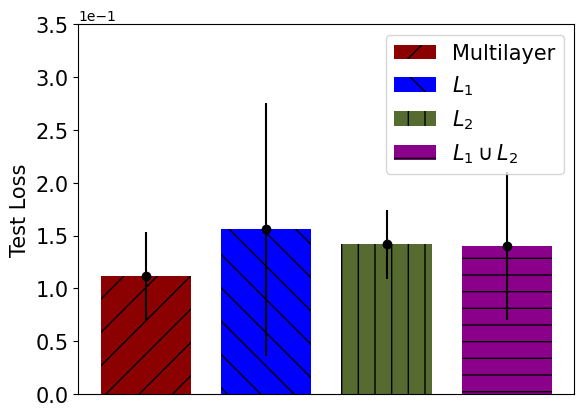

In [23]:
def plot_test_loss(alg_results):
    fig, axes = plt.subplots()
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    d = ['lightcoral', 'cornflowerblue', 'lightgreen', 'pink']
    c = ['indianred', 'royalblue', 'greenyellow', 'hotpink']
    m = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    hatches = ['/', '\\', '|', '-']
    i = 0
    for algname in alg_results:
        x = np.arange(1)  # the label locations
        width = 0.15     # the width of the bars
        offset = width * i
        axes.bar(x + offset, alg_results[algname]['test_loss_mean'], 3*width/4, 
                label=names_plot[i], color = m[i],
                hatch=hatches[i])
        axes.errorbar(x + offset, alg_results[algname]['test_loss_mean'],
                      alg_results[algname]['test_loss_std'],
                            fmt="o", color='black')
        i += 1
    plt.tick_params(axis='x',          # changes apply to the x-axis
                    which='both',      # both major and minor ticks are affected
                    bottom=False,      # ticks along the bottom edge are off
                    top=False,         # ticks along the top edge are off
                    labelbottom=False) # labels along the bottom edge are off
    plt.ylim(top=0.35)
    plt.legend(fontsize=15)
    plt.ticklabel_format(axis='both', style='sci', scilimits=(-1,-1))
    plt.ylabel('Test Loss', fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig(f'./Figures/test_loss_twitter.png', bbox_inches='tight', dpi=1000)
    plt.show()
    
plot_test_loss(alg_results)

### Plot distribution of average predicted alphas  

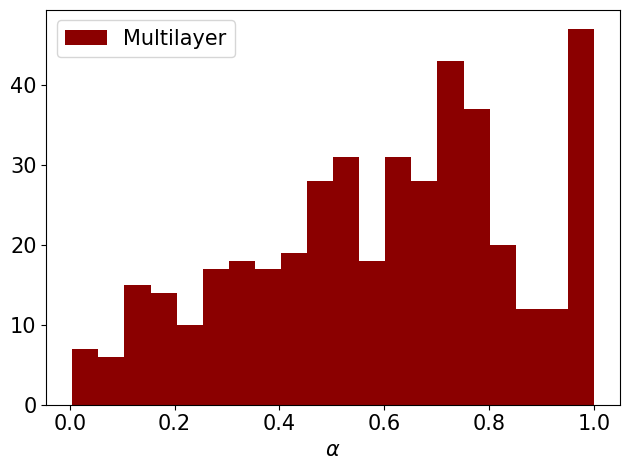

In [24]:
def plot_alphas_distribution(alg_results):
    colors = ['darkred', 'blue', 'darkolivegreen', 'darkmagenta']
    names_plot = ['Multilayer', r'$L_1$', r'$L_2$', r'$L_1\cup L_2$']
    i = 0
    for algname in alg_results:
        plt.hist(np.array(alg_results[algname]['alphas_mean']), bins=20, 
                 color = colors[i] ,label = names_plot[i], alpha = 1)
        i += 1
        break
    plt.legend()
    plt.legend(fontsize=15)
    plt.xlabel(r'$\alpha$', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.tight_layout()
    plt.savefig(f'./Figures/alpha_distribution_twitter.png')
    plt.show()
    
plot_alphas_distribution(alg_results)

### Predicted layer parameters

In [14]:
for algname in alg_results:
    print(f'For {algname} lambdas are: {alg_results[algname]["lambdas_mean"].T[0]}')

For multi lambdas are: [0.63000366 0.36999634]
For l1 lambdas are: [0.5 0.5]
For l2 lambdas are: [0.5 0.5]
For lboth lambdas are: [0.5 0.5]
